In [1]:
import pandas as pd
import numpy as np
from encoder import Encoder

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier)



import xgboost as xgb 

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ip_data = pd.read_csv('data/IpAddress_to_Country.csv')

In [3]:
ip_data.tail()

,lower_bound_ip_address,upper_bound_ip_address,country
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore
138845,3.758096e+09,3758096383,Australia


In [4]:
ip_data['ip_range'] = list(zip(ip_data.lower_bound_ip_address, ip_data.upper_bound_ip_address))

In [5]:
fraud_data = pd.read_csv('data/Fraud_Data.csv')

In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


### Determine Country based on IP address

In [8]:
v = ip_data.loc[:, 'lower_bound_ip_address':'upper_bound_ip_address'].apply(tuple, 1).tolist()

In [9]:
idx = pd.IntervalIndex.from_tuples(v, closed='both')

In [10]:
v = ip_data.loc[:, 'lower_bound_ip_address':'upper_bound_ip_address'].apply(tuple, 1).tolist()
idx = pd.IntervalIndex.from_tuples(v, closed='both')
fraud_data['country'] = ip_data.loc[idx.get_indexer(fraud_data['ip_address'].values), 'country'].values

/Users/gnishimura/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [11]:
fraud_data.iloc[17]

user_id                        119824
signup_time       2015-03-20 00:31:27
purchase_time     2015-04-05 07:31:46
purchase_value                     55
device_id               WFIIFCPIOGMHT
source                            Ads
browser                        Safari
sex                                 M
age                                38
ip_address                     131424
class                               0
country                           NaN
Name: 17, dtype: object

In [12]:
test = fraud_data.iloc[17]['ip_address']

In [13]:
list(ip_data[(ip_data['lower_bound_ip_address'] < test) & 
        (ip_data['upper_bound_ip_address'] > test)]['country'])

[]

### Clean Data 

In [14]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [15]:
#fraud_data['country'].value_counts()

In [16]:
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'], infer_datetime_format=True)

In [17]:
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'], infer_datetime_format=True)

In [18]:
fraud_data['time_to_purchase'] = fraud_data['purchase_time'] - fraud_data['signup_time']

In [19]:
fraud_data['days_to_purchase'] = fraud_data['time_to_purchase'].apply(lambda x: x.days)

In [20]:
y_labels = fraud_data['class']

In [21]:
percent_fraud = (y_labels.sum()/len(y_labels))*100
percent_fraud

9.364577267192546

In [22]:
clean_fraud_data = fraud_data.drop(['class', 'user_id', 'device_id', 
                                    'time_to_purchase', 'signup_time', 
                                    'purchase_time', 'ip_address'], axis=1)

In [23]:
clean_fraud_data.head()

,purchase_value,source,browser,sex,age,country,days_to_purchase
0,34,SEO,Chrome,M,39,Japan,52
1,16,Ads,Chrome,F,53,United States,0
2,15,SEO,Opera,M,53,United States,0
3,44,SEO,Safari,M,41,NaN,5
4,39,Ads,Safari,M,45,United States,50


### Train-Test-Split and Dummify

In [24]:
X_train, X_test, y_train, y_test = train_test_split(clean_fraud_data, y_labels, test_size=.3)

In [25]:
encoder = Encoder(thresh=3)

In [26]:
encoder.fit(X_train)

In [27]:
encoded_X_train = encoder.transform(X_train)

In [28]:
encoded_X_train.columns

Index(['purchase_value', 'age', 'days_to_purchase', 'source_SEO', 'source_Ads',
       'browser_Chrome', 'browser_IE', 'browser_Safari', 'browser_FireFox',
       'sex_M',
       ...
       'country_Malawi', 'country_Afghanistan', 'country_Congo',
       'country_Faroe Islands', 'country_Cote D'ivoire', 'country_Curacao',
       'country_Haiti', 'country_Djibouti', 'country_Cameroon',
       'country_Reunion'],
      dtype='object', length=153)

In [29]:
encoded_X_test = encoder.transform(X_test)

In [30]:
encoded_X_test.columns

Index(['purchase_value', 'age', 'days_to_purchase', 'source_SEO', 'source_Ads',
       'browser_Chrome', 'browser_IE', 'browser_Safari', 'browser_FireFox',
       'sex_M',
       ...
       'country_Malawi', 'country_Afghanistan', 'country_Congo',
       'country_Faroe Islands', 'country_Cote D'ivoire', 'country_Curacao',
       'country_Haiti', 'country_Djibouti', 'country_Cameroon',
       'country_Reunion'],
      dtype='object', length=153)

In [31]:
encoded_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45334 entries, 68135 to 78438
Columns: 153 entries, purchase_value to country_Reunion
dtypes: int64(153)
memory usage: 53.3 MB


### First Model: Logistic Regression 

In [32]:
lr = LogisticRegression()

In [33]:
lr.fit(encoded_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
y_preds = lr.predict_proba(encoded_X_train)

In [35]:
lr_y_preds = lr.predict_proba(encoded_X_test)

In [36]:
lr_log_loss = log_loss(y_test, lr_y_preds)
print(f"log loss for logistic regression model was {lr_log_loss}")

log loss for logistic regression model was 0.2766172743016411


In [37]:
hard_preds = lr.predict(encoded_X_test)

In [38]:
accuracy_score(y_test, hard_preds)

0.90642784664931397

In [39]:
betas = lr.coef_

In [40]:
def create_readable_coef_df(coefficients, df):
    features_arr = np.array(df.columns)
    coef_arr = np.array(coefficients).flatten()
    table = np.concatenate([features_arr, coef_arr]).reshape(2, len(df.columns))
    coef_df = pd.DataFrame(table)
    coef_df.columns = coef_df.iloc[0]
    coef_df.drop(index=0, inplace=True)
    return coef_df

In [41]:
coefs = create_readable_coef_df(betas, encoded_X_train).T

In [42]:
coefs.sort_values(by=1, ascending=False)

,1
0,
country_Luxembourg,1.37065
country_Sri Lanka,1.35505
country_Peru,1.23981
country_New Zealand,1.20316
country_Tunisia,1.10392
country_Kuwait,1.06129
country_Namibia,0.965266
country_Ecuador,0.958709
country_Saudi Arabia,0.854378


### Second Model: Random Forest

In [43]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=20)

In [44]:
rf.fit(encoded_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=20, verbose=0, warm_start=False)

In [45]:
rf_preds = rf.predict_proba(encoded_X_test)

In [46]:
print(f"log loss for random forest = {log_loss(y_test, rf_preds)}")

log loss for random forest = 0.23633728614302435


([array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   1.10000000e+01,   6.30000000e+01,
           2.54600000e+03,   0.00000000e+00,   9.00000000e+00,
           4.27050000e+04]),
  array([  4.27050000e+04,   9.00000000e+00,   0.00000000e+00,
           2.54600000e+03,   6.30000000e+01,   1.10000000e+01,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00])],
 array([ 0.06763159,  0.15410527,  0.24057895,  0.32705264,  0.41352632,
         0.5       ,  0.58647368,  0.67294736,  0.75942105,  0.84589473,
         0.93236841]),
 <a list of 2 Lists of Patches objects>)

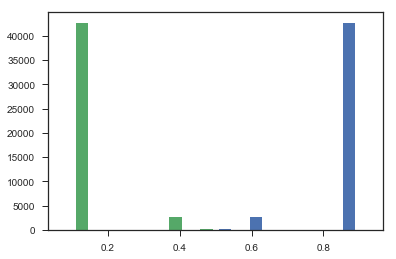

In [47]:
plt.hist(rf_preds)

### Third Model: XG Boost

In [48]:
xgb_model_1 = xgb.XGBClassifier()

In [49]:
xgb_model_1.fit(encoded_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
xgb_preds_1 = xgb_model_1.predict_proba(encoded_X_test)

In [51]:
log_loss_score = log_loss(y_test, xgb_preds_1)

In [52]:
print(f'log_loss for xgboost = {log_loss_score}')

log_loss for xgboost = 0.1992708325736562


In [53]:
print(xgb_model_1.feature_importances_)

[ 0.15360983  0.11367127  0.17511521  0.06298003  0.06451613  0.03072197
  0.02304148  0.00614439  0.00921659  0.03072197  0.0015361   0.          0.0015361
  0.          0.00614439  0.01382488  0.01075269  0.01536098  0.01075269
  0.          0.0030722   0.01382488  0.0015361   0.0015361   0.00460829
  0.00460829  0.0030722   0.00460829  0.          0.          0.
  0.01382488  0.00460829  0.          0.00614439  0.          0.
  0.01228879  0.          0.          0.00768049  0.          0.
  0.00768049  0.01382488  0.00460829  0.0030722   0.00768049  0.02304148
  0.01382488  0.          0.00768049  0.          0.          0.00768049
  0.0030722   0.          0.          0.          0.          0.
  0.00614439  0.          0.01689708  0.00460829  0.00614439  0.          0.
  0.01228879  0.          0.00768049  0.          0.          0.          0.
  0.          0.          0.01536098  0.00460829  0.          0.          0.
  0.          0.          0.          0.01228879  0.0030722 

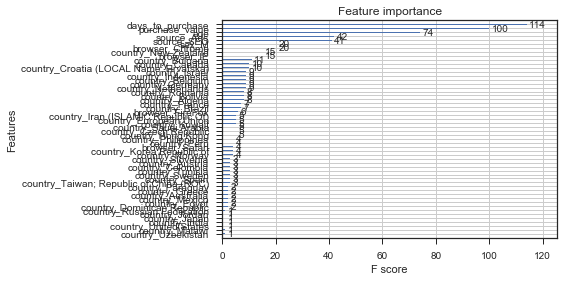

In [54]:
xgb.plot_importance(xgb_model_1)

# Attempt to Tune XGBoost 

### Try setting up early stopping rounds to ensure overfitting is not happening

In [55]:
eval_set = [(encoded_X_test, y_test)]

In [57]:
xgb_model_1.fit(encoded_X_train, y_train, early_stopping_rounds=10, 
              eval_metric='logloss', eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.616297
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.553507
[2]	validation_0-logloss:0.501445
[3]	validation_0-logloss:0.45781
[4]	validation_0-logloss:0.42093
[5]	validation_0-logloss:0.389558
[6]	validation_0-logloss:0.362742
[7]	validation_0-logloss:0.339738
[8]	validation_0-logloss:0.319973
[9]	validation_0-logloss:0.302917
[10]	validation_0-logloss:0.288212
[11]	validation_0-logloss:0.275507
[12]	validation_0-logloss:0.264523
[13]	validation_0-logloss:0.25506
[14]	validation_0-logloss:0.246877
[15]	validation_0-logloss:0.239824
[16]	validation_0-logloss:0.233746
[17]	validation_0-logloss:0.228515
[18]	validation_0-logloss:0.224014
[19]	validation_0-logloss:0.220162
[20]	validation_0-logloss:0.216871
[21]	validation_0-logloss:0.214057
[22]	validation_0-logloss:0.211657
[23]	validation_0-logloss:0.209618
[24]	validation_0-logloss:0.207891
[25]	validation_0-logloss:0.206432
[26]	validation_0-logloss:0.205202


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

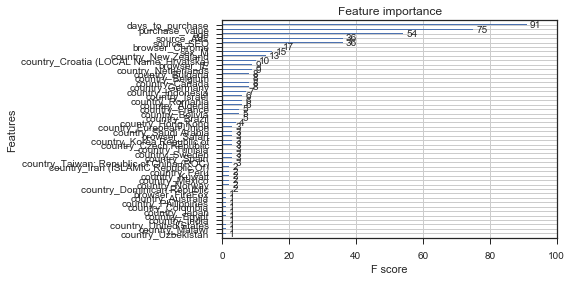

In [58]:
xgb.plot_importance(xgb_model_1)

In [60]:
xgb_preds = xgb_model_1.predict_proba(encoded_X_test)

In [61]:
ll = log_loss(y_test, xgb_preds)
ll

0.19922602697528141

### Perform Gridsearch to find the best hyperparameters

In [62]:
n_estimators = [50, 100 ,150, 200]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

In [63]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [65]:
grid_search = GridSearchCV(xgb_model_1, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)

In [ ]:
gird_result = grid_search.fit(encoded_X_train, y_train)

In [ ]:
print(gird_result.best_estimator_)

#### Well, that was pretty useless...  Best parameters turn out to be the defaults

# Interpreting Results 

### ROC

In [ ]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_preds[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_preds[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_y_preds)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cnf_matrix = confusion_matrix(y_test, lr_y_preds)

In [ ]:
lr_y_preds